In [1]:
import os
import numpy as np
import sys
import pandas as pd
from pathlib import Path
import tensorflow as tf
from datetime import datetime

# TFRecords Datasets in Action
So it was fun to call `next` on the dataset and print some data but how would we use in training a real ANN?(and I say real loosely) Well this example has got you covered. We are going to assume the tf records exist already and use them to fit an ANN. Thus we need to split up our data into train and valid (we are going to skip test for now) and do preprocessing to scale, batch, shuffle, etc. our data.

## TFRecord Files
First get all the tfrecord files and split them up into train and valid

In [2]:
tfrecord_path = Path('/opt/data/MagData/tfrecords/')
tfrecord_files = [tfrecord_path / file_name for file_name in os.listdir(tfrecord_path)]
train_files = tfrecord_files[:7]
valid_files = tfrecord_files[7:]

# Read TFRecords
This next chunk is just a function version of the code we used when writing/exploring the dataset. The only notable thing is that we call the function on two different sets of files to make a train and valid dataset.

In [3]:
def get_dataset(record_files: Path):
    def _parse_function(serialized):
        features = {
            'input': tf.io.FixedLenFeature([], tf.string),
            'output': tf.io.FixedLenFeature([], tf.float32)
        }
        # Parse the serialized data so we get a dict with our data.
        parsed_example = tf.io.parse_single_example(serialized=serialized, features=features)
        # cast the example to our data type

        # the vector of x input data
        x_sample_bytes = parsed_example['input']
        # Decode the raw bytes so it becomes a tensor with type.
        # we gave it float64 so thats what we need to decode
        x_sample_float64 = tf.io.decode_raw(x_sample_bytes, tf.float64)
        # however we usually want float32 for ANNs
        x_sample_float32 = tf.cast(x_sample_float64, tf.float32)
        x_sample = x_sample_float32

        # we don't need to do anything special to our y output data because it is one value
        y_sample = parsed_example['output']

        # return our samples as a tuple
        return x_sample, y_sample

    # annoyingly the TFRecordDataset function wants string not cool Path objects
    filename_str = [str(filename) for filename in record_files]
    # create a tfrecord dataset from the list of tfrecord files
    dataset = tf.data.TFRecordDataset(filenames=filename_str,
                                      compression_type=None,
                                      buffer_size=None,
                                      num_parallel_reads=tf.data.experimental.AUTOTUNE)
    # Parse the serialized data in the TFRecords files.
    # This returns TensorFlow tensors for the image and labels.
    dataset = dataset.map(map_func=_parse_function,
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return dataset

train_dataset = get_dataset(train_files)
valid_dataset = get_dataset(valid_files)

# Pipeline Pre-Processing
Now we build the function to pre-process our data. The first thing we need to do is scale the data. We are using the means and standard deviations from when we wrote all the data. To do the scaling we are going to call a custom mapping function.

In [4]:
y_scale = 1172.838237
y_bias = -0.000074
# do the scaling on our image batches
def mapper(x_sample, y_sample):
    x_mean = tf.constant([-0.016558, -0.006312, 0.354091, 0.002300, .005623])
    x_std = tf.constant([0.603413, 0.598194, 0.390447, 0.450745, 0.454901])
    x_sample = (x_sample - x_mean) / x_std
    
    y_mean = tf.constant([y_bias])
    y_std = tf.constant([y_scale])
    y_sample = (y_sample - y_mean) / y_std
    return x_sample, y_sample

Next we are going to reapeat, shuffle, scale, batch and prefetch our data in a pipeline

In [5]:
batch_size = 100
num_shuffle_batches = 3

def repeat_shuffle_scale_batch_prefetch_dataset(dataset):
    # repeat
    dataset = dataset.repeat()
    # shuffle
    dataset = dataset.shuffle(buffer_size=batch_size * num_shuffle_batches)
    # map
    dataset = dataset.map(map_func=mapper, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # chain together batch and prefetch
    dataset = dataset.batch(batch_size=batch_size).prefetch(1)
    return dataset
    
train_dataset = repeat_shuffle_scale_batch_prefetch_dataset(train_dataset)
valid_dataset = repeat_shuffle_scale_batch_prefetch_dataset(valid_dataset)

Finally we are goint to read in one sample to check we get the shapes we expect

In [6]:
np_iterator = train_dataset.as_numpy_iterator()
sample = next(np_iterator)
sample[0].shape, sample[1].shape

((100, 5), (100, 1))

So that should be a tuple of our features and labels. We also batched this so the first dimension of each is the batch size. The last dimension should be the data size

## Build the ANN
Now we can actually build our ANN

In [7]:
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
import tensorflow.keras.losses

metrics = ['mae']
last_layer_activation = 'linear'
optimizer = RMSprop(learning_rate=0.001)
loss_fn = tensorflow.keras.losses.mse

feature_size = sample[0].shape[-1]
output_size = sample[1].shape[-1]
layer_size = 20
steps_per_epoch = 70
validation_steps = 30
n_epochs = 100

input_tensor = Input(shape=(feature_size,))

current_output = Dense(units=layer_size, activation='relu')(input_tensor)
current_output = Dense(units=output_size, activation=last_layer_activation)(current_output)

model = Model(inputs=input_tensor, outputs=current_output)

model.compile(loss=loss_fn, metrics=metrics, optimizer=optimizer)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense (Dense)               (None, 20)                120       
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 141
Trainable params: 141
Non-trainable params: 0
_________________________________________________________________


Finally we will train the ANN using our newly created datasets. To do this we will use the `fit` function like normal but we will make the `x` argument the dataset and give nothing for `y`. Note this new `steps_per_epoch` variable we have to give. Since our generator will make data forever we need to actaully call out how many batches we want to do in one epoch. Same with the validation data. 

In [8]:
start_time = datetime.now()
model.fit(train_dataset, 
          steps_per_epoch=steps_per_epoch, 
          epochs=n_epochs,
          validation_data=valid_dataset,
          validation_steps=validation_steps)
end_time = datetime.now()

Epoch 1/100
70/70 [==============================] - 1s 4ms/step - loss: 0.5271 - mae: 0.5949 - val_loss: 0.2885 - val_mae: 0.4351
Epoch 2/100
70/70 [==============================] - 0s 3ms/step - loss: 0.1421 - mae: 0.2896 - val_loss: 0.0539 - val_mae: 0.1798
Epoch 3/100
70/70 [==============================] - 0s 3ms/step - loss: 0.0273 - mae: 0.1276 - val_loss: 0.0122 - val_mae: 0.0880
Epoch 4/100
70/70 [==============================] - 0s 3ms/step - loss: 0.0073 - mae: 0.0679 - val_loss: 0.0049 - val_mae: 0.0562
Epoch 5/100
70/70 [==============================] - 0s 3ms/step - loss: 0.0042 - mae: 0.0519 - val_loss: 0.0037 - val_mae: 0.0483
Epoch 6/100
70/70 [==============================] - 0s 3ms/step - loss: 0.0033 - mae: 0.0458 - val_loss: 0.0030 - val_mae: 0.0436
Epoch 7/100
70/70 [==============================] - 0s 3ms/step - loss: 0.0027 - mae: 0.0412 - val_loss: 0.0024 - val_mae: 0.0387
Epoch 8/100
70/70 [==============================] - 0s 3ms/step - loss: 0.0022 - m

70/70 [==============================] - 0s 3ms/step - loss: 1.7042e-04 - mae: 0.0103 - val_loss: 1.5811e-04 - val_mae: 0.0098
Epoch 61/100
70/70 [==============================] - 0s 3ms/step - loss: 1.5870e-04 - mae: 0.0099 - val_loss: 1.6014e-04 - val_mae: 0.0100
Epoch 62/100
70/70 [==============================] - 0s 3ms/step - loss: 1.6692e-04 - mae: 0.0102 - val_loss: 1.8231e-04 - val_mae: 0.0106
Epoch 63/100
70/70 [==============================] - 0s 3ms/step - loss: 1.5828e-04 - mae: 0.0099 - val_loss: 1.8993e-04 - val_mae: 0.0112
Epoch 64/100
70/70 [==============================] - 0s 3ms/step - loss: 1.5764e-04 - mae: 0.0099 - val_loss: 1.4229e-04 - val_mae: 0.0093
Epoch 65/100
70/70 [==============================] - 0s 3ms/step - loss: 1.5997e-04 - mae: 0.0100 - val_loss: 2.4296e-04 - val_mae: 0.0131
Epoch 66/100
70/70 [==============================] - 0s 3ms/step - loss: 1.5873e-04 - mae: 0.0099 - val_loss: 1.3257e-04 - val_mae: 0.0090
Epoch 67/100
70/70 [=============

In [9]:
f"Time to fit: {(end_time-start_time).seconds}"

'Time to fit: 20'

## Examine our Output
In order to actually get an idea of our error metrics we should look at them in the unscaled domain (before we normalized our data). To do this we will multiply the error by the scaling factor. The tricky part is that since we used a dataset we cannot actually use the predict function on the dataset because it will not give us the label. Thus we have to extract the x (inputs) and y (truth) first so we can do our work.

In [10]:
def extract_dataset(dataset: tf.data.Dataset, eval_samples=6000):
    x_visualize = []
    y_visualize = []

    total_samples = 0
    img_batch: np.ndarray
    label_batch: np.ndarray
    for img_batch, label_batch in dataset.as_numpy_iterator():
        total_samples += img_batch.shape[0]
        x_visualize.append(img_batch)
        y_visualize.append(label_batch)
        if total_samples > eval_samples:
            break

    x_visualize = np.vstack(x_visualize)
    y_visualize = np.vstack(y_visualize)
    return x_visualize, y_visualize

input_train, output_train = extract_dataset(train_dataset, eval_samples=7000)
input_valid, output_valid = extract_dataset(valid_dataset, eval_samples=3000)

output_train = (output_train * y_scale) - y_bias
output_valid = (output_valid * y_scale) - y_bias

input_train.shape, output_train.shape

((7100, 5), (7100, 1))

Now we can do the prediction and unscale our prediction. We can also compare to the truth.

In [11]:
predictions_train = model.predict(input_train)
predictions_train_unscaled = (predictions_train * y_scale) - y_bias
mae_train = np.mean(np.abs((output_train - predictions_train_unscaled)))

predictions_valid = model.predict(input_valid)
predictions_valid_unscaled = (predictions_valid * y_scale) - y_bias
mae_valid = np.mean(np.abs((output_valid - predictions_valid_unscaled)))
(mae_train, mae_valid)

(10.317972, 10.56328)

I guess those are good numbers but maybe we should visualize them to get a better idea if this is good or not

## Visualize
Usually I like to see the data visually. Here is a simple idea how about I plot the truth as green dots and the predictions as red ones. I guess I have to spread these out over the x axis or else they will just be all jumbled on top of each other.

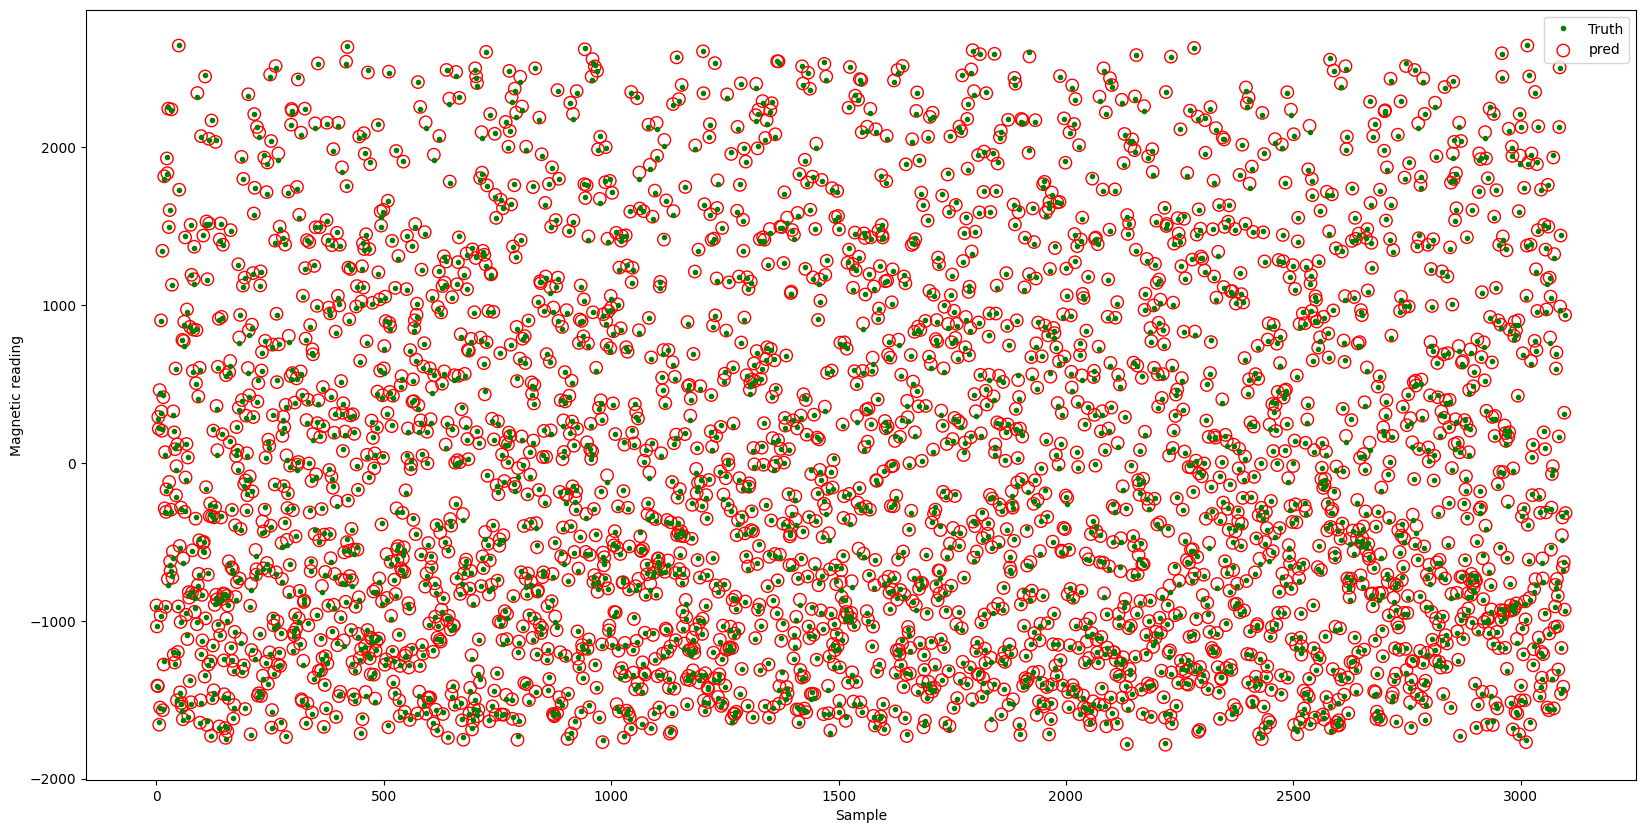

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))
plt.plot(output_valid, 'g.', label='Truth')
plt.scatter(range(predictions_valid_unscaled.shape[0]), predictions_valid_unscaled,
            s=80, facecolors='none', edgecolors='r', label='pred')

plt.ylabel('Magnetic reading')
plt.xlabel('Sample')
plt.legend()
plt.show()

The looks pretty good I guess. Most of the green dots are in the red circles. But I don't like how the x axis doesn't have a lot of meaning.

How about we plot the truth on one axis and the prediction on the other. If its good it should be a 45 degree line.

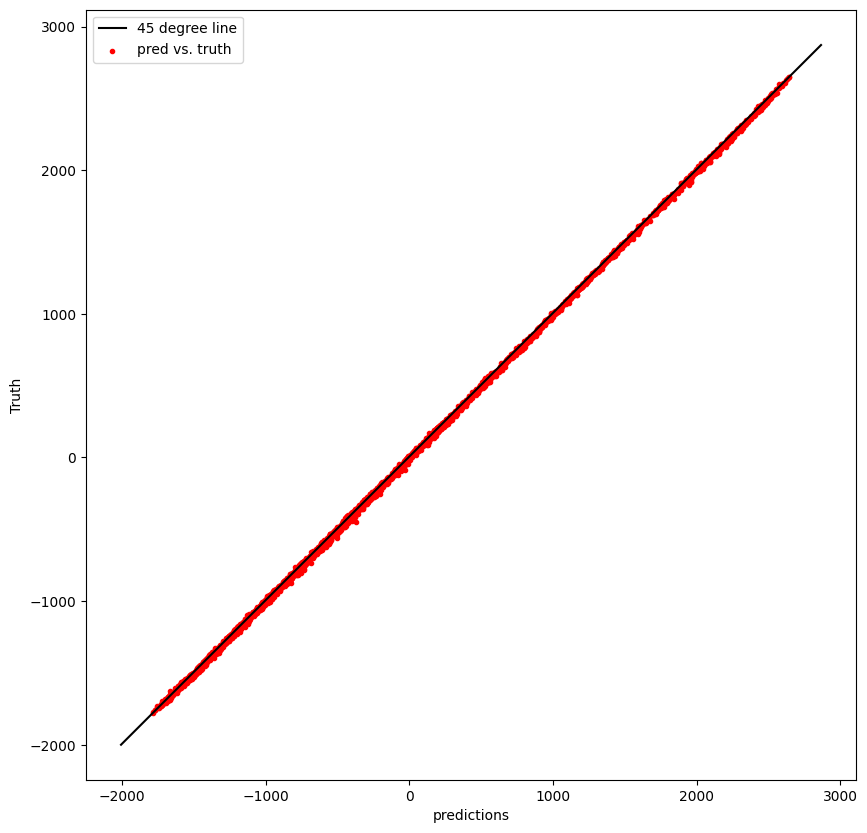

In [13]:
plt.figure(figsize=(20, 10))
plt.scatter(predictions_valid_unscaled, output_valid, c='r', marker='.', label='pred vs. truth')
plt.xlabel('predictions')
plt.ylabel('Truth')
# overlay the 45 degree line
plt.plot(plt.xlim(), plt.ylim(), 'k', label='45 degree line')
plt.axis('square')
plt.legend()
plt.show()

That looks much better. Our samples in red closely follow the black line and now both axes have meaning.

## Histograms and Cumulative Distribution plots
We may also want to look at the error distributions instead of the whole values. First lets look at the median and the mean

In [14]:
maerror = np.abs(predictions_valid_unscaled- output_valid)
print(f"MAE Median: {np.percentile(maerror, 50)}")
print(f"MAE Mean: {maerror.mean()}")

MAE Median: 8.52264404296875
MAE Mean: 10.56328010559082


Now how about we look at the entire histogram and cumulative histogram

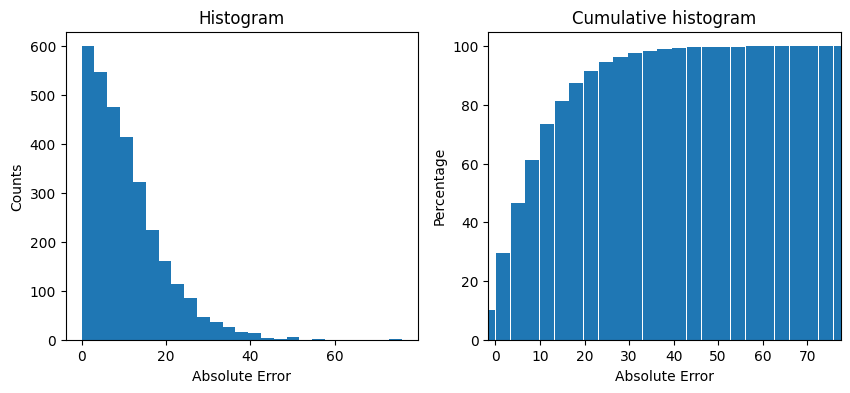

In [15]:
import scipy.stats
res = scipy.stats.cumfreq(maerror, numbins=25)
x = res.lowerlimit + np.linspace(0, res.binsize*res.cumcount.size, res.cumcount.size)

fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.hist(maerror, bins=25)
ax1.set_title('Histogram')
ax1.set_xlabel('Absolute Error')
ax1.set_ylabel('Counts')
ax2.bar(x, res.cumcount/res.cumcount.max() * 100, width=res.binsize)
ax2.set_title('Cumulative histogram')
ax2.set_xlim([x.min(), x.max()])
ax2.set_xlabel('Absolute Error')
ax2.set_ylabel('Percentage')
plt.show()

This is much more descriptive of our errors compared to single values.

So I used the term ANN loosely because this is a really easy problem to solve even with a 1 layer ANN.

# Multiprocessing Generators
Sometimes your generator can be slow to make a new batch. In this case it wastes GPU time if the program waits for the the next batch and does nothing on the GPU. 

If we use multiprocessing we can make multiple batches in parallel. The batches are then put in a queue for the training function. In this way as long as something is on the queue we will not waste GPU time.

However datasets apparently do all of this for us (using prefetch, cache, etc.) so it becomes irrelevant? IF you do use a normal generator (instead of a fancy TFDataset) then this will matter however.

In [16]:
input_tensor = Input(shape=(feature_size,))

current_output = Dense(units=layer_size, activation='relu')(input_tensor)
current_output = Dense(units=output_size, activation=last_layer_activation)(current_output)

model = Model(inputs=input_tensor, outputs=current_output)

model.compile(loss=loss_fn, metrics=metrics, optimizer=optimizer)
model.summary()

start_time = datetime.now()
model.fit(train_dataset, 
        steps_per_epoch=steps_per_epoch, 
        epochs=n_epochs,
        validation_data=valid_dataset,
        validation_steps=validation_steps,
        max_queue_size=500,
        workers=8,
        use_multiprocessing=True)
end_time = datetime.now()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense_2 (Dense)             (None, 20)                120       
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 141
Trainable params: 141
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
70/70 [==============================] - 1s 4ms/step - loss: 0.8260 - mae: 0.7723 - val_loss: 0.4232 - val_mae: 0.5547
Epoch 2/100
70/70 [==============================] - 0s 3ms/step - loss: 0.1978 - mae: 0.3676 - val_loss: 0.0521 - val_mae: 0.1919
Epoch 3/100
70/70 [==============================] - 0s 3ms/ste

70/70 [==============================] - 0s 3ms/step - loss: 1.8525e-04 - mae: 0.0107 - val_loss: 1.9384e-04 - val_mae: 0.0108
Epoch 55/100
70/70 [==============================] - 0s 3ms/step - loss: 1.8756e-04 - mae: 0.0107 - val_loss: 2.0224e-04 - val_mae: 0.0111
Epoch 56/100
70/70 [==============================] - 0s 3ms/step - loss: 1.8767e-04 - mae: 0.0108 - val_loss: 1.8947e-04 - val_mae: 0.0109
Epoch 57/100
70/70 [==============================] - 0s 3ms/step - loss: 1.8472e-04 - mae: 0.0107 - val_loss: 1.9586e-04 - val_mae: 0.0113
Epoch 58/100
70/70 [==============================] - 0s 3ms/step - loss: 1.8123e-04 - mae: 0.0106 - val_loss: 1.7456e-04 - val_mae: 0.0104
Epoch 59/100
70/70 [==============================] - 0s 3ms/step - loss: 1.8321e-04 - mae: 0.0106 - val_loss: 1.7716e-04 - val_mae: 0.0106
Epoch 60/100
70/70 [==============================] - 0s 3ms/step - loss: 1.8310e-04 - mae: 0.0107 - val_loss: 2.2121e-04 - val_mae: 0.0119
Epoch 61/100
70/70 [=============

In [17]:
f"Time to fit: {(end_time-start_time).seconds}"

'Time to fit: 20'

We can also use the evaluate funciton with a generator

In [18]:
model.evaluate(valid_dataset, steps=100)

100/100 [==============================] - 0s 1ms/step - loss: 2.2589e-04 - mae: 0.0122


[0.00022588868159800768, 0.012218245305120945]

What we are looking at here is the loss and the mae. if we ever forget we can ask the model what the metrics are.

In [20]:
model.metrics_names

['loss', 'mae']

Remember these numbers are still the scaled versions so we cannot say much about them even if they look really small. That is what we had all the visualization for.